<a href="https://colab.research.google.com/github/cfsarmiento/GenAI-Research/blob/main/ChatGPT_poll_composite_vars_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ChatGPT Poll Composite Var creation and Analysis
Modified by: EL

Things added, changed:
- Added helper class for PCA-weighted composite socre creation
- Read the ChatGPT-Clean.csv data
- Relabeled the variables for readability purposes (may still need more changes)
- Recoded Likert vars to numbers (int)
- COmpute composite scores and conbach alphas on subsets of variables.

Singleton variable are due to the fact that the cronbach-alpha coeff was below 0.7


In [1]:
#!pip install vaderSentiment --quiet
#!pip install pingouin --quiet
!pip install openpyxl --quiet

In [2]:
# Imports
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from scipy.stats import zscore
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
#import pingouin as pg
#import researchpy as rp  # for statistical tests
#from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer  # for sentiment analysis
import warnings
warnings.filterwarnings('ignore')

## Helper class - PCA-weighted  composite score creation

In [3]:
class LikertCompositeCalculator:
    def __init__(self, data, withPCA=True):
        # Standardization: This is needed for PCA - values are measured in stddevs:  (xi-xi_mean)/xi_sd
        # Also to be able to compare likert scale variables with different scales
        # the withPCA boolean value determines whether PCA is used to compte the weights, or if the variables are just averaged
        self.data = zscore(data, ddof=1)
        self.withPCA = withPCA

    def calc_ca(self):
        # Calculated manually (checking the package)
        k = self.data.shape[1]
        if k>1:
          variance_sum = self.data.var(axis=0, ddof=1).sum()
          total_variance = self.data.sum(axis=1).var(ddof=1)
          cronbach_alpha = (k / (k - 1)) * (1 - (variance_sum / total_variance))
        else:
          cronbach_alpha = 1
        return cronbach_alpha

    def calc2_ca(self):
        # USing pingouin
        if  self.data.shape[1] >1:
          cronbach_alpha =pg.cronbach_alpha(self.data)
        else:
          cronbach_alpha = 1
        return cronbach_alpha

    def calc_composite_score(self):
        # Step 1: Perform PCA (data already standardized)
        pca = PCA()
        pca.fit(self.data)

        # Step 2: Calculate Weights
        if self.withPCA:
          weights = pca.components_[0] / np.sum(pca.components_[0])
        else:
         k = self.data.shape[1]
         broadcast_value= (1.0/k)
         weights = np.full(k, broadcast_value)

        # Step 3: Calculate Composite Scores
        composite_scores = np.dot(self.data, weights)

        return composite_scores, weights

## Read in clean poll results

In [4]:
# Read in clean poll results
# I placed the file you provided in my website at Marist, was easier to load the data for me
data = pd.read_csv('https://foxweb.marist.edu/users/jf4n/Research/ChatGPTSurvey/ChatGPT-Clean.csv')

In [5]:
data.sample(20)

,Q2,Q4,Q5,Q6,Q7_1,Q7_2,Q7_3,Q8_1,Q8_2,Q8_3,...,Q15_9,Q17,Q19,Q21,Q22,Q23,sex,age,occupation/school,student/faculty
94,A great deal,From the news,To aid in completion of a project,To aid in completion of a project,Strongly agree,Somewhat agree,Somewhat agree,Strongly agree,Strongly agree,Strongly agree,...,Strongly agree,Strongly agree,Neither agree nor disagree,Somewhat likely,Somewhat unlikely,Very strong tool that can help people out in a...,Male,18-21,CS & Math,Student
47,A little,From a colleague,To get started with a project,Curiosity,Somewhat agree,Somewhat agree,Somewhat agree,Somewhat agree,Somewhat agree,Somewhat agree,...,Somewhat agree,Somewhat agree,Somewhat agree,Somewhat likely,Somewhat likely,It seems like a good idea in some ways because...,Female,18-21,Communications & Arts,Student
204,A great deal,From the news,To obtain significant help with a project,Other; please specify,Neither agree nor disagree,Strongly agree,Strongly agree,Neither agree nor disagree,Neither agree nor disagree,Neither agree nor disagree,...,NaN,NaN,NaN,NaN,NaN,I am concerned about students learning how to ...,Female,46+,Professor/Faculty,Professor/Faculty
160,A good amount,From a colleague,To obtain significant help with a project,To obtain significant help with a project,Somewhat disagree,Somewhat agree,Strongly disagree,Somewhat disagree,Somewhat disagree,Somewhat agree,...,Somewhat disagree,Somewhat agree,Strongly disagree,Neither likely nor unlikely,Somewhat unlikely,Could be a new tool for student plagiarism,Female,46+,Professor/Faculty,Professor/Faculty
22,A good amount,From the news,To aid in completion of a project,To get started with a project,Strongly agree,Neither agree nor disagree,Somewhat agree,Strongly agree,Strongly agree,Strongly agree,...,Strongly agree,Strongly agree,Strongly agree,Very likely,Somewhat likely,"Great tool, especially when you need fast info...",Female,22-25,CS & Math,Student
255,A good amount,From a friend,To aid in completion of a project,Curiosity,Neither agree nor disagree,Neither agree nor disagree,Somewhat agree,Somewhat disagree,Neither agree nor disagree,Somewhat disagree,...,Strongly agree,Strongly agree,Strongly agree,Very likely,Very likely,ChatGPT can increase productivity but at the s...,Female,18-21,Social & Behavioral Sciences,Student
114,A good amount,From the news,To obtain significant help with a project,Curiosity,Neither agree nor disagree,Somewhat agree,Somewhat agree,Somewhat agree,Strongly agree,Neither agree nor disagree,...,Neither agree nor disagree,Strongly agree,Somewhat agree,Somewhat likely,Neither likely nor unlikely,I suppose that it's really could be used as he...,Male,18-21,CS & Math,Student
345,A great deal,From the news,Curiosity,Curiosity,Somewhat agree,Somewhat agree,Strongly agree,Neither agree nor disagree,Somewhat disagree,Somewhat agree,...,NaN,Somewhat agree,Neither agree nor disagree,Somewhat likely,Very unlikely,NaN,Male,22-25,Management,Student
65,A great deal,Other,To obtain significant help with a project,To obtain significant help with a project,Strongly agree,Neither agree nor disagree,Neither agree nor disagree,Somewhat agree,Somewhat agree,Somewhat agree,...,Somewhat agree,Strongly agree,Strongly agree,Somewhat likely,Somewhat likely,NaN,Male,22-25,CS & Math,Student
190,A great deal,From the news,To obtain significant help with a project,To obtain significant help with a project,Somewhat agree,Strongly agree,Strongly agree,Somewhat agree,Somewhat disagree,Somewhat disagree,...,Strongly agree,Somewhat agree,Neither agree nor disagree,Somewhat unlikely,Somewhat unlikely,"Unless you give it very specific prompts, thro...",Female,46+,Professor/Faculty,Professor/Faculty


In [6]:
#data.info()

In [7]:
new_column_names = {'Q2':    'Q2_AWARENESS',
                    'Q4':    'SOURCE',
                    'Q5':    'Q5_REASON_STUDENT',
                    'Q6':    'Q6_REASON_PROF',
                    'Q7_1':  'Q71_BENEFITS',
                    'Q7_2':  'Q72_LIMITATIONS',
                    'Q7_3':  'Q73_IMPLICATIONS',
                    'Q8_1':  'Q81_LIKELY_PRODUCTIVE',
                    'Q8_2':  'Q82_PRODUCTIVE_STUDENT',
                    'Q8_3':  'Q83_PRODUCTIVE_PROF',
                    'Q8_4':  'Q84_PRODUCTIVE_PERSON',
                    'Q9_1':  'Q91_PLAG_STUDENT',
                    'Q9_2':  'Q92_PLAG_PROF',
                    'Q9_3':  'Q93_PLAG_PERSON',
                    'Q9_4':  'Q94_CAUGHT_PLAG',
                    'Q10':   'Q10_SOC_IMPACT',
                    'Q11':   'Q11_HIGHERED_BENEFIT',
                    'Q12':   'Q12_RESP_USE',
                    'Q13':   'Q13_FREQ_USE',
                    'Q14':   'Q14_RESP_REASON_USE',
                    'Q15_1': 'Q151_RESP_WILL_USE',
                    'Q15_2': 'Q152_RESP_BENEFIT',
                    'Q15_3': 'Q153_RESP_PRODUCTIVE',
                    'Q15_4': 'Q154_RESP_FEEL_PLAG',
                    'Q15_5': 'Q155_RESP_TRUST_OUTPUT',
                    'Q15_6': 'Q156_RESP_USE_OUTPUT',
                    'Q15_7': 'Q157_RESP_WILL_PLAG',
                    'Q15_8': 'Q158_RESP_PRODUCTIVE',
                    'Q15_9': 'Q159_RESP_IMPACTED',
                    'Q17':   'Q17_ACCURATE_OUTPUT_DELIVERY',
                    'Q19':   'Q19_ACCURATE_OUTPUT_COUNTRY',
                    'Q21':   'Q21_TRUST_OUTPUT_COAT',
                    'Q22':   'Q22_USE_OUTPUT_COAT',
                    'Q23':   'Q23_THOUGHTS',
                    'sex':   'GENDER',
                    'age':   'AGE_RANGE',
                    'occupation/school': 'OCCUP_SCHOOL',
                    'student/faculty':   'OCCUPATION'

					}

In [8]:
df = data.rename(columns=new_column_names)
#df.info()

In [9]:
df.groupby('AGE_RANGE').count()['SOURCE']

AGE_RANGE
18-21    180
22-25     50
26-29     14
30-33     11
34-37      7
38-41     17
42-45     13
46+       63
Name: SOURCE, dtype: int64

## Check missing values

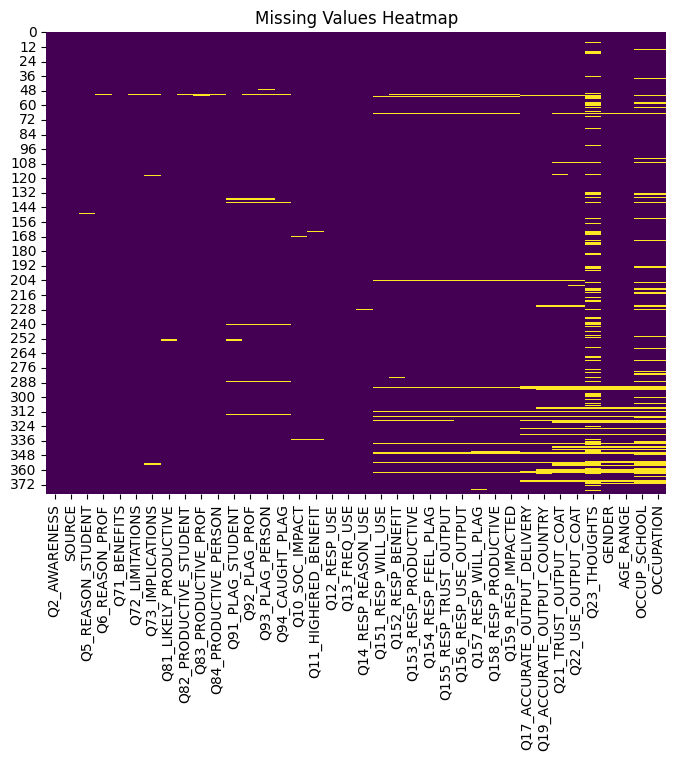

In [10]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.isnull(), cmap='viridis', cbar=False)
plt.title("Missing Values Heatmap")
plt.show()

## Remove nulls, recode and drop Q23-THOUGHTS

In [11]:
df1 = df.drop("Q23_THOUGHTS", axis=1).dropna()
df1['OCCUPATION'] = df1['OCCUPATION'].replace('Professor/Faculty', 'Instructor')
#--------------------------
df1['GENDER'] = df1['GENDER'].replace('Non-binary / third gender', 'NB3')
df1['GENDER'] = df1['GENDER'].replace('Prefer not to say', 'PNTS')
#-----------------------------------------------------------------
df1['SOURCE'] = df1['SOURCE'].replace('From a colleague', 'colleague')
df1['SOURCE'] = df1['SOURCE'].replace('From a family member', 'familymember')
df1['SOURCE'] = df1['SOURCE'].replace('From a family member', 'familymember')
df1['SOURCE'] = df1['SOURCE'].replace('From a family member', 'familymember')
df1['SOURCE'] = df1['SOURCE'].replace('From the news', 'news')
df1['SOURCE'] = df1['SOURCE'].replace('From this questionnaire', 'questionnaire')
df1['SOURCE'] = df1['SOURCE'].replace('None', 'none')
#---------------------------------------------------------
def recode_age_range(age_range):
    if age_range in ['18-21']:
        return '18-21'
    elif age_range in ['22-25', '26-29']:
        return '22-29'
    elif age_range in ['30-33', '34-37', '38-41']:
        return '30-41'
    elif age_range in ['42-45']:
        return '42-45'
    elif age_range in ['46+']:
        return '46+'
    else:
        return age_range

# Apply the function to the AGE_RANGE column
df1['AGE_RANGE']=df['AGE_RANGE'].apply(recode_age_range)
#---------------------------------------------------------
print(df1.shape[0])
#df1["OCCUPATION"].sample(20)

302


In [12]:
df1.groupby('AGE_RANGE').count()['SOURCE']

AGE_RANGE
18-21    160
22-29     50
30-41     27
42-45     10
46+       55
Name: SOURCE, dtype: int64

## Plot  the distribution by demographic vars

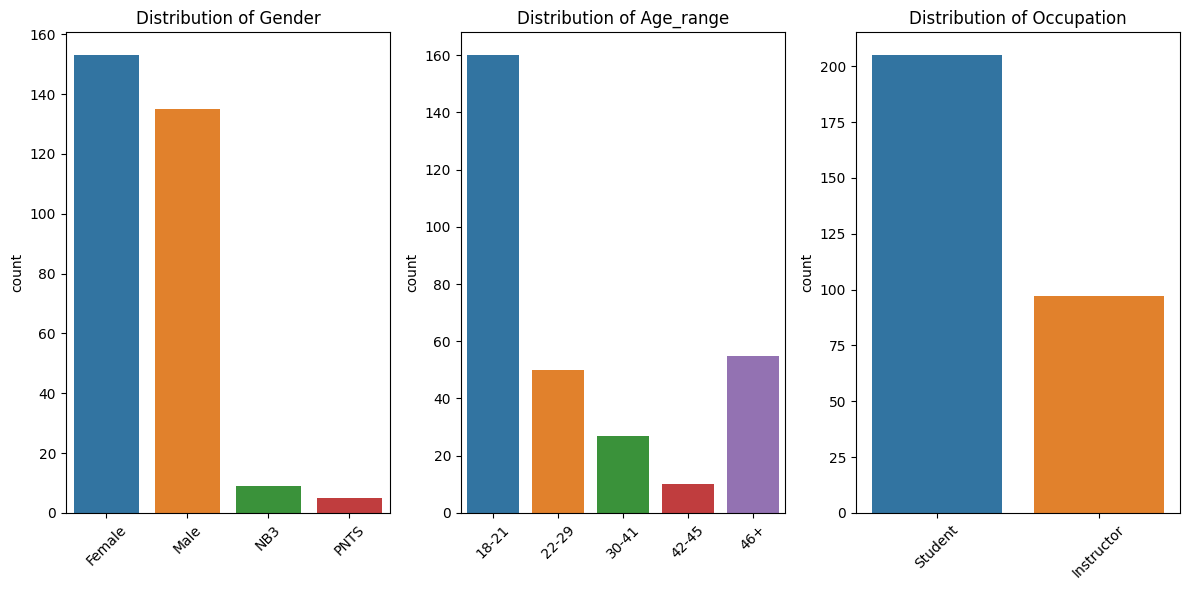

In [13]:
# Dictionary of demographic features and their categories
demog_features = {
    'GENDER': ['Female', 'Male', 'NB3', 'PNTS'],
    'AGE_RANGE': ['18-21', '22-29', '30-41', '42-45', '46+'],
    'OCCUPATION': ['Student', 'Instructor']
}

# Set up the 1x3 plot grid
fig, axes = plt.subplots(nrows=1, ncols=len(demog_features), figsize=(12, 6))

# Loop through each demog_feature and create a count plot
for i, column in enumerate(demog_features):
    sns.countplot(x=column, data=df1, ax=axes[i], order=demog_features[column])
    axes[i].set_title(f'Distribution of {column.capitalize()}')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].set_xlabel(None)  # Remove xlabel, if needed

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


## Recoding of Likert vars

In [14]:
##Likert (1-3) vars ----------------------------------------------------------------
likert3_mapping1 = {'Very much so':1,
                   'Somewhat':2,
                   'Not at all':3}
df1['Q10_SOC_IMPACT'] = df1['Q10_SOC_IMPACT'].map(likert3_mapping1)
df1['Q11_HIGHERED_BENEFIT'] = df1['Q11_HIGHERED_BENEFIT'].map(likert3_mapping1)

##Likert (1-4) vars ---------------------------------------------------------------
likert4_mapping1 = {'A great deal':1,
                   'A good amount':2,
                   'A little':1,
                   'Nothing at all':4}

df1['Q2_AWARENESS'] = df1['Q2_AWARENESS'].map(likert4_mapping1)


likert4_mapping2 = {'Quite a lot':1,
                   'A good amount':2,
                   'A little':1,
                   'Not at all':4}

df1['Q12_RESP_USE'] = df1['Q12_RESP_USE'].map(likert4_mapping2)


likert4_mapping3 = {'11 or more times':1,
                    '6 to 10':2,
                    '1 to 5':3,
                    '0':4}

df1['Q13_FREQ_USE'] = df1['Q13_FREQ_USE'].map(likert4_mapping3)

##Likert (1-5) vars -----------------------------------------------
likert5_mapping1 = {'Strongly agree':1,
                  'Somewhat agree':2,
                  'Neither agree nor disagree':3,
                  'Somewhat disagree':4,
                  'Strongly disagree':5}

inverse_likert5_mapping1 = {'Strongly agree':5,
                           'Somewhat agree':4,
                           'Neither agree nor disagree':3,
                           'Somewhat disagree':2,
                           'Strongly disagree':1}

for colname  in ['Q71_BENEFITS','Q72_LIMITATIONS','Q73_IMPLICATIONS',
                'Q81_LIKELY_PRODUCTIVE','Q82_PRODUCTIVE_STUDENT','Q83_PRODUCTIVE_PROF','Q84_PRODUCTIVE_PERSON',
                'Q91_PLAG_STUDENT','Q92_PLAG_PROF','Q93_PLAG_PERSON','Q94_CAUGHT_PLAG',
                'Q151_RESP_WILL_USE','Q152_RESP_BENEFIT','Q153_RESP_PRODUCTIVE','Q154_RESP_FEEL_PLAG',
                'Q155_RESP_TRUST_OUTPUT','Q156_RESP_USE_OUTPUT','Q157_RESP_WILL_PLAG','Q158_RESP_PRODUCTIVE','Q159_RESP_IMPACTED',
                'Q17_ACCURATE_OUTPUT_DELIVERY','Q19_ACCURATE_OUTPUT_COUNTRY'] :

     #keep direction (1-5)
     if colname in ['Q71_BENEFITS', 'Q72_LIMITATIONS','Q73_IMPLICATIONS',
                    'Q81_LIKELY_PRODUCTIVE','Q82_PRODUCTIVE_STUDENT','Q83_PRODUCTIVE_PROF','Q84_PRODUCTIVE_PERSON',
                    'Q91_PLAG_STUDENT','Q92_PLAG_PROF','Q93_PLAG_PERSON',
                    'Q151_RESP_WILL_USE','Q152_RESP_BENEFIT','Q153_RESP_PRODUCTIVE',
                    'Q155_RESP_TRUST_OUTPUT','Q156_RESP_USE_OUTPUT','Q158_RESP_PRODUCTIVE','Q159_RESP_IMPACTED',
                    'Q17_ACCURATE_OUTPUT_DELIVERY','Q19_ACCURATE_OUTPUT_COUNTRY']:
        df1[colname] = df1[colname].map(likert5_mapping1)
     else:
        df1[colname] = df1[colname].map(inverse_likert5_mapping1)


likert5_mapping2 = {'To obtain significant help with a project':1,
                    'To aid in completion of a project':2,
                    'To get started with a project':3,
                    'Curiosity':4,
                    'I have not used ChatGPT':5}
df1['Q14_RESP_REASON_USE'] = df1['Q14_RESP_REASON_USE'].map(likert5_mapping2)

likert5_mapping3 = {'Very likely':1,
                    'Somewhat likely':2,
                    'Neither likely nor unlikely':3,
                    'Somewhat unlikely':4,
                    'Very unlikely':5}
df1['Q21_TRUST_OUTPUT_COAT'] = df1['Q21_TRUST_OUTPUT_COAT'].map(likert5_mapping3)
df1['Q22_USE_OUTPUT_COAT'] = df1['Q22_USE_OUTPUT_COAT'].map(likert5_mapping3)


likert5_mapping4 = {'To obtain significant help with a project':1,
                    'To aid in completion of a project':2,
                    'To get started with a project':3,
                    'Curiosity':4,
                    'Other; please specify':5}
df1['Q5_REASON_STUDENT'] = df1['Q5_REASON_STUDENT'].map(likert5_mapping4)
df1['Q6_REASON_PROF'] = df1['Q6_REASON_PROF'].map(likert5_mapping4)


## Now we create subsets, compute reliability and create composites
Thisa section ends with the creation of an  Excel file.

In [15]:
# Example usage
subset_dict = {
    'AWARENESS': ['Q2_AWARENESS'],
    'REASON_STUDENT': ['Q5_REASON_STUDENT'],
    'REASON_PROFESSIONAL': ['Q6_REASON_PROF'],
    'BENEFITS': ['Q71_BENEFITS'],
    'LIMITATIONS': ['Q72_LIMITATIONS'],
    'IMPLICATIONS': ['Q73_IMPLICATIONS'],
    'WORK_PRODUCTIVITY': ['Q81_LIKELY_PRODUCTIVE','Q82_PRODUCTIVE_STUDENT','Q83_PRODUCTIVE_PROF','Q84_PRODUCTIVE_PERSON'],
    'PLAGIARISM': ['Q91_PLAG_STUDENT','Q92_PLAG_PROF','Q93_PLAG_PERSON'],
    'SOCIAL_IMPACT': ['Q10_SOC_IMPACT'],
    'HIGHERED_BENEFIT': ['Q11_HIGHERED_BENEFIT'],
    'USAGE': ['Q12_RESP_USE','Q13_FREQ_USE','Q14_RESP_REASON_USE'],
    'RESP_USE_TRUST_BENEF': ['Q151_RESP_WILL_USE','Q152_RESP_BENEFIT','Q153_RESP_PRODUCTIVE','Q154_RESP_FEEL_PLAG',
                              'Q155_RESP_TRUST_OUTPUT','Q156_RESP_USE_OUTPUT','Q157_RESP_WILL_PLAG','Q158_RESP_PRODUCTIVE','Q159_RESP_IMPACTED'],
    'ACCURACY': ['Q17_ACCURATE_OUTPUT_DELIVERY','Q19_ACCURATE_OUTPUT_COUNTRY'],
    'TRUST': ['Q21_TRUST_OUTPUT_COAT','Q22_USE_OUTPUT_COAT']
}
composite_info = []
df2 = pd.DataFrame()

for subset_name, subset_variables in subset_dict.items():
        subset = df1[subset_variables]
        lcc = LikertCompositeCalculator(subset,withPCA=True)

        # Add the composite variable to the original DataFrame
        composite_var_name = subset_name
        composite_score, weights = lcc.calc_composite_score()
        df2[composite_var_name] = composite_score

        # Calculate Cronbach's alpha
        cronbach_alpha = lcc.calc_ca()
        #print(subset_name,list(zip(subset_variables,weights)),lcc.calc_ca(),'\n' )

        # Add information to the composite info list
        composite_info.append({'SubsetName': subset_name,'subset': list(zip(subset_variables,weights)), 'CronbachAlpha': cronbach_alpha})

# Create a new df, augmented with the composites
result_df = pd.concat([df1.reset_index(drop=True), df2.reset_index(drop=True)], axis=1)

# Create a DataFrame to store composite information
composite_info_df = pd.DataFrame(composite_info)


In [16]:
composite_info_df['subset'][6]

[('Q81_LIKELY_PRODUCTIVE', 0.2695951460824908),
 ('Q82_PRODUCTIVE_STUDENT', 0.26392241664318844),
 ('Q83_PRODUCTIVE_PROF', 0.2783267451215751),
 ('Q84_PRODUCTIVE_PERSON', 0.18815569215274552)]

In [17]:
result_df

,Q2_AWARENESS,SOURCE,Q5_REASON_STUDENT,Q6_REASON_PROF,Q71_BENEFITS,Q72_LIMITATIONS,Q73_IMPLICATIONS,Q81_LIKELY_PRODUCTIVE,Q82_PRODUCTIVE_STUDENT,Q83_PRODUCTIVE_PROF,...,LIMITATIONS,IMPLICATIONS,WORK_PRODUCTIVITY,PLAGIARISM,SOCIAL_IMPACT,HIGHERED_BENEFIT,USAGE,RESP_USE_TRUST_BENEF,ACCURACY,TRUST
0,1,news,1,2,4,4,4,3,3,3,...,2.171730,2.373974,0.705744,-1.463215,0.969679,1.707759,0.895819,1.543423,0.254953,1.750332
1,2,news,3,2,1,1,1,1,2,1,...,-1.022405,-0.821896,-0.721571,-0.073755,-0.907521,-1.149544,-0.751619,-0.549300,-0.296804,-0.685842
2,2,From a friend,3,3,1,2,2,1,2,2,...,0.042306,0.243394,-0.587772,-0.628901,0.969679,-1.149544,-0.676335,-0.765636,-1.025810,-0.685842
3,1,familymember,2,2,1,1,1,2,2,2,...,-1.022405,-0.821896,-0.297750,-0.407348,0.969679,0.279107,-1.315724,-0.708271,-0.109550,-0.685842
4,4,From a friend,4,1,1,2,2,1,3,1,...,0.042306,0.243394,-0.141898,0.798437,-0.907521,-1.149544,0.895819,-0.631084,0.067700,-1.123160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,1,news,1,3,1,1,1,2,2,2,...,-1.022405,-0.821896,-0.122395,-0.371065,0.969679,0.279107,-1.552690,-0.473446,-0.296804,1.313014
298,2,news,1,4,3,1,1,3,5,4,...,-1.022405,-0.821896,1.297468,-0.926211,0.969679,0.279107,-0.751619,0.681038,1.910223,1.750332
299,2,familymember,2,2,1,2,1,2,4,4,...,0.042306,-0.821896,0.953839,-0.369470,-0.907521,0.279107,0.895819,0.980047,0.254953,0.063638
300,1,news,2,4,1,3,5,1,1,1,...,1.107018,3.439263,-1.301245,-0.369470,0.969679,-1.149544,0.895819,-0.665683,-0.296804,-0.311102


In [18]:
#result_df.to_csv('coded_data.csv', index=False)
#composite_info_df.to_csv('composite_info_df', index=False)

In [19]:
import os
excel_filename = 'pollcodeddata.xlsx'
if os.path.exists(excel_filename):
    os.remove(excel_filename)

# Create an ExcelWriter object
with pd.ExcelWriter(excel_filename) as writer:
    # Write each DataFrame to a different worksheet
    result_df.to_excel(writer, sheet_name='coded_data', index=False)
    composite_info_df.to_excel(writer, sheet_name='composite_info', index=False)

#Remove comment if you want to download Excel file
#from google.colab import files
#files.download('pollcodeddata.xlsx')

___________________________________________
# Create bar charts

In [20]:
def  create_bar_graphs(categorical_var_name,categorical_var_ordered_values, variables, num_rows, num_cols, figsize=(16, 12)):

  # Create a list of categorical variables
  # You can replace this with your actual categorical variable data
  categorical_var = result_df[categorical_var_name]
  cat_codes = categorical_var_ordered_values  # Unique categorical codes


  # Create a figure and axes for the subplots
  fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
  fig.subplots_adjust(hspace=0.5)  # Adjust the vertical spacing between subplots

  # Loop over each variable and subplot
  for i, variable in enumerate(variables):
    row = i // num_cols
    col = i % num_cols

    ax = axes[row, col]

    # Replace this with your actual data
    # Generate mock data for demonstration
    data = result_df[variable]

    # Create the bar plot
    sns.barplot(x=categorical_var, y=data, ax=ax)

    # Set the xticks and labels
    ax.set_xticks(np.arange(len(categorical_var.unique())))
    ax.set_xticklabels(np.arange(len(categorical_var.unique())))

    # Set the title of the subplot
    ax.set_title(variable)
    ax.set_xlabel('')
    ax.set_ylabel('')

    # Set the legend
    #ax.legend([variable], loc='upper left')

  # Remove any unused subplots
  for i in range(len(variables), num_rows * num_cols):
    fig.delaxes(axes.flatten()[i])

  # Create code-description pairs
  code_desc_pairs = [f"{code}:{desc}" for code, desc in zip(np.arange(len(categorical_var.unique())),cat_codes)]
  bottom_legend = categorical_var_name +'. '+', '.join(code_desc_pairs)

  # Add code-description text at the bottom of the grid
  fig.text(0.1, -0.02, bottom_legend,fontsize = 11, ha='left')

  # Show the plots
  plt.tight_layout()
  plt.show()

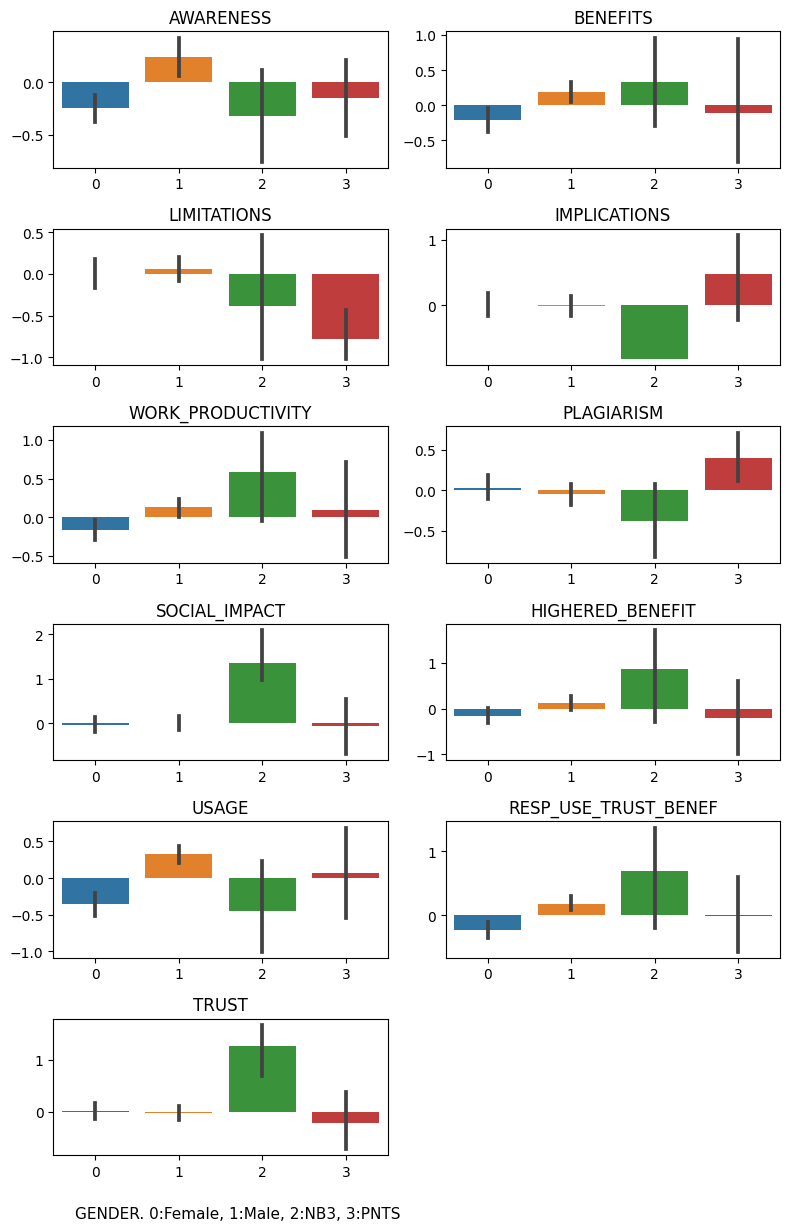

In [21]:
# Define the list of variables
variables = ['AWARENESS', 'BENEFITS', 'LIMITATIONS', 'IMPLICATIONS',
             'WORK_PRODUCTIVITY', 'PLAGIARISM', 'SOCIAL_IMPACT',
             'HIGHERED_BENEFIT', 'USAGE', 'RESP_USE_TRUST_BENEF', 'TRUST']

categorical_var_name='GENDER'
categorical_var_ordered_values = ['Female', 'Male', 'NB3', 'PNTS']


num_rows = 6
num_cols = 2

create_bar_graphs(categorical_var_name,categorical_var_ordered_values, variables, num_rows, num_cols, figsize=(8,12))

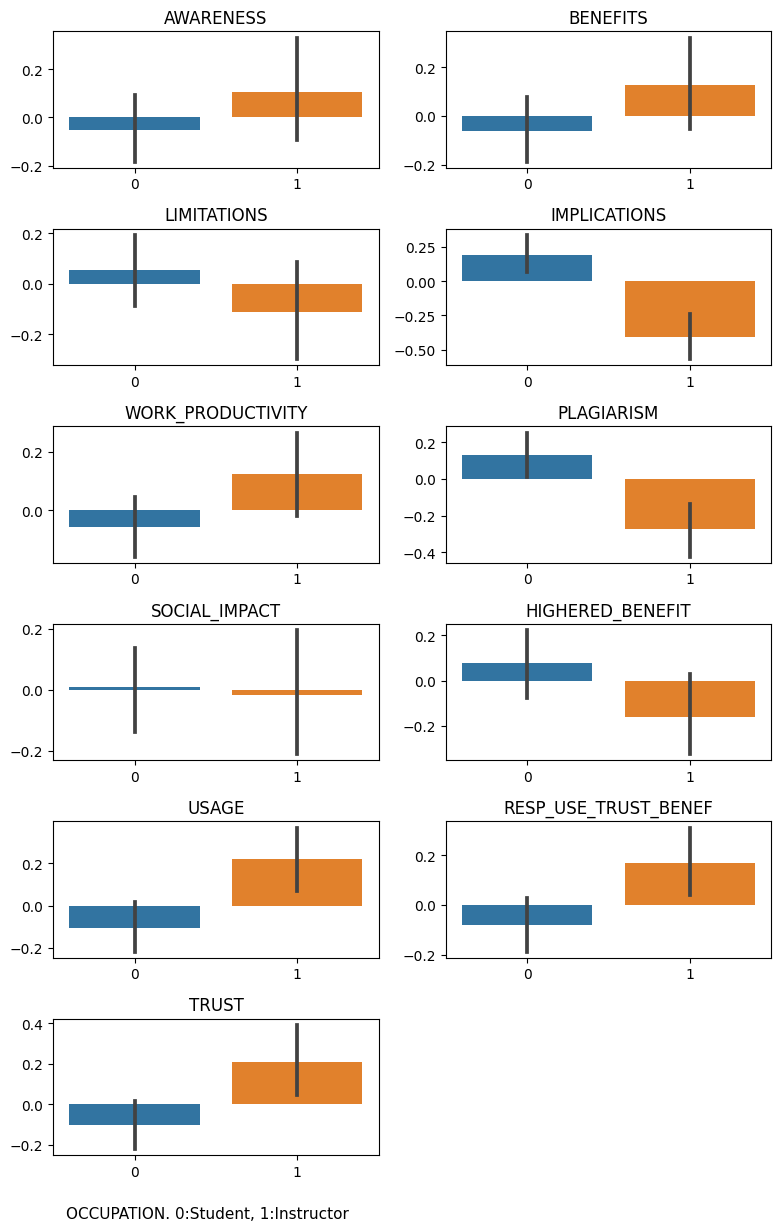

In [22]:
# Define the list of variables
variables = ['AWARENESS', 'BENEFITS', 'LIMITATIONS', 'IMPLICATIONS',
             'WORK_PRODUCTIVITY', 'PLAGIARISM', 'SOCIAL_IMPACT',
             'HIGHERED_BENEFIT', 'USAGE', 'RESP_USE_TRUST_BENEF', 'TRUST']

categorical_var_name='OCCUPATION'
categorical_var_ordered_values = ['Student', 'Instructor']

num_rows = 6
num_cols = 2

create_bar_graphs(categorical_var_name,categorical_var_ordered_values, variables, num_rows, num_cols, figsize=(8,12))

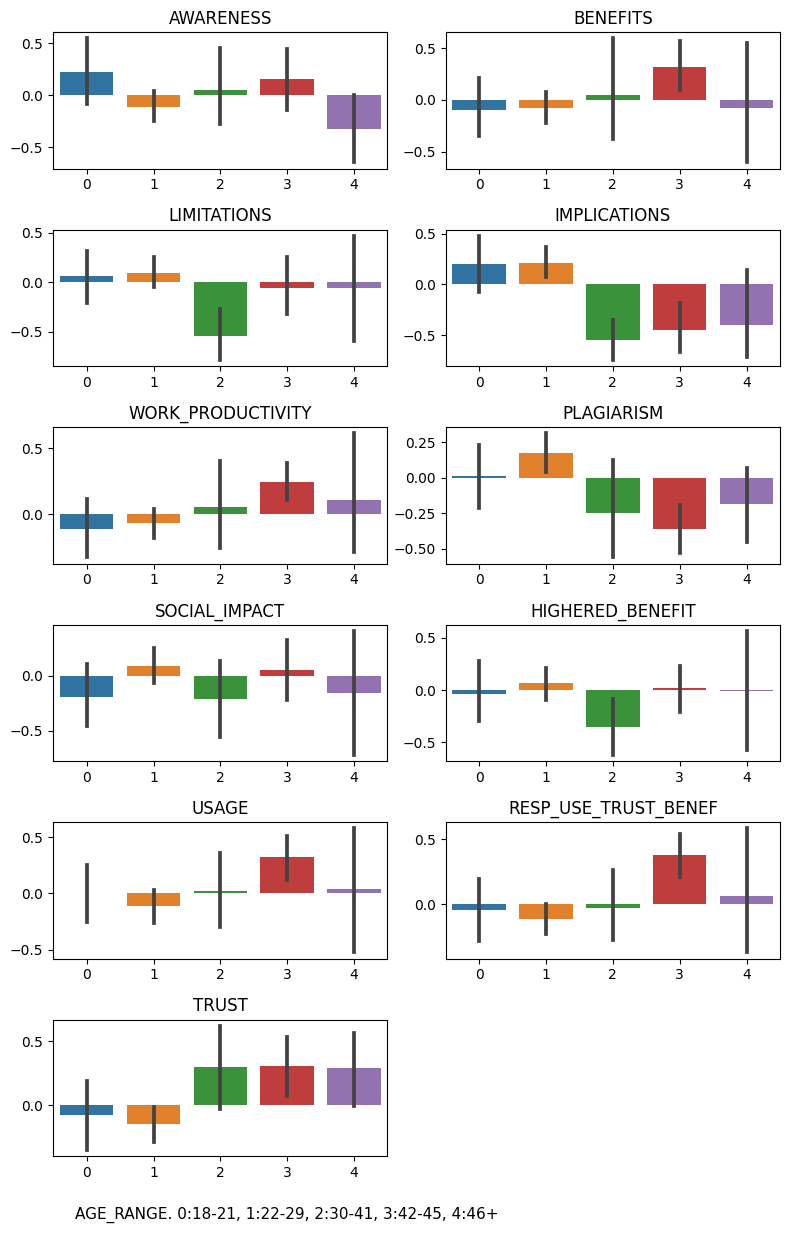

In [23]:
# Define the list of variables
variables = ['AWARENESS', 'BENEFITS', 'LIMITATIONS', 'IMPLICATIONS',
             'WORK_PRODUCTIVITY', 'PLAGIARISM', 'SOCIAL_IMPACT',
             'HIGHERED_BENEFIT', 'USAGE', 'RESP_USE_TRUST_BENEF', 'TRUST']

categorical_var_name='AGE_RANGE'
categorical_var_ordered_values = ['18-21', '22-29', '30-41', '42-45', '46+']

num_rows = 6
num_cols = 2

create_bar_graphs(categorical_var_name,categorical_var_ordered_values, variables, num_rows, num_cols, figsize=(8,12))

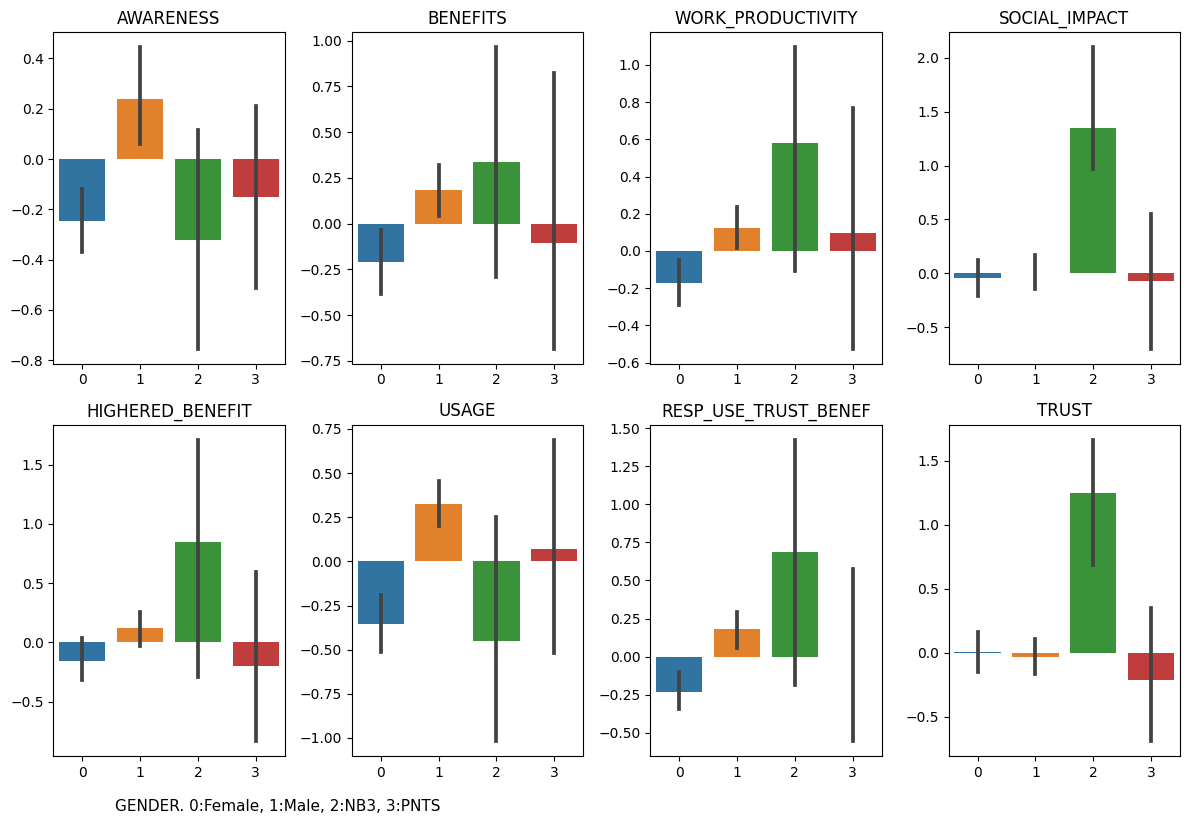

In [24]:
# Define the list of variables that are significant
variables = ['AWARENESS', 'BENEFITS', 'WORK_PRODUCTIVITY', 'SOCIAL_IMPACT',
             'HIGHERED_BENEFIT', 'USAGE', 'RESP_USE_TRUST_BENEF', 'TRUST']

categorical_var_name='GENDER'
categorical_var_ordered_values = ['Female', 'Male', 'NB3', 'PNTS']

num_rows = 2
num_cols = 4

create_bar_graphs(categorical_var_name,categorical_var_ordered_values, variables, num_rows, num_cols, figsize=(12,8))

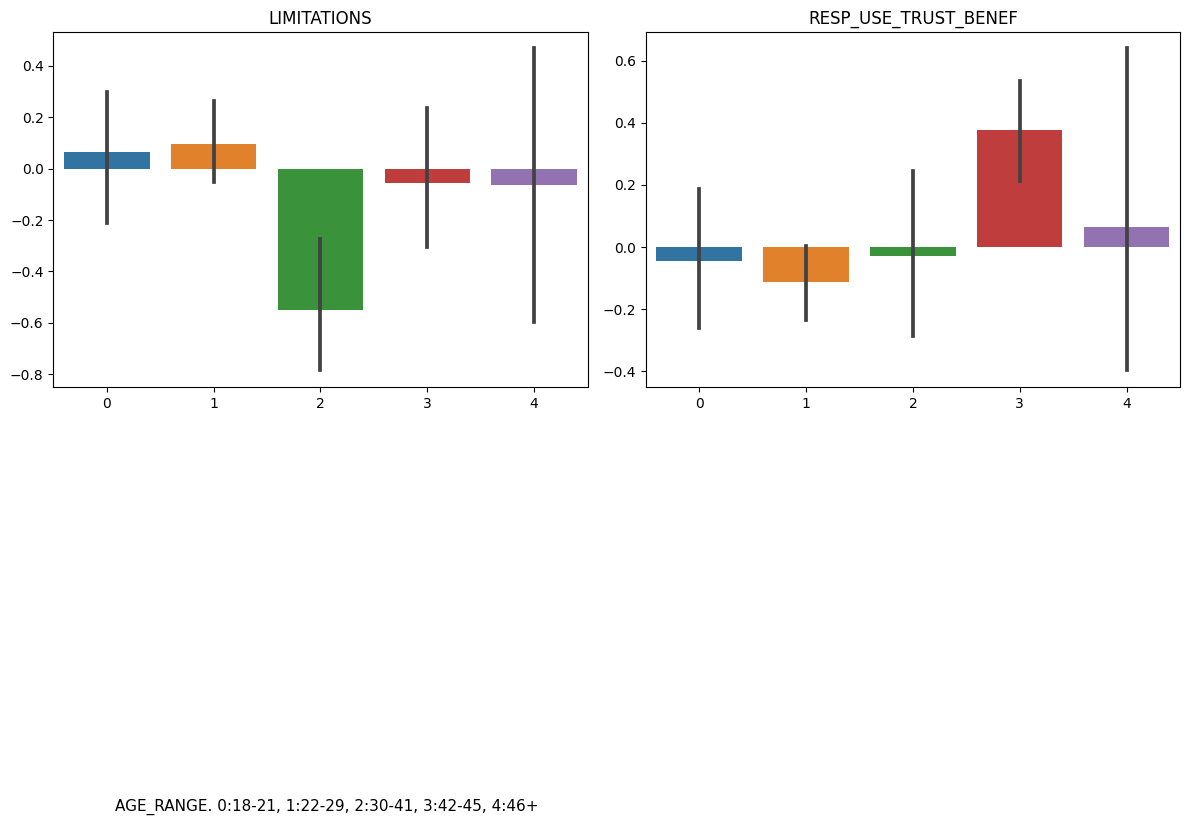

In [25]:
# Define the list of variables that are significant
variables = [ 'LIMITATIONS','RESP_USE_TRUST_BENEF']

categorical_var_name='AGE_RANGE'
categorical_var_ordered_values = ['18-21', '22-29', '30-41', '42-45', '46+']

num_rows = 2
num_cols = 2

create_bar_graphs(categorical_var_name,categorical_var_ordered_values, variables, num_rows, num_cols, figsize=(12,8))

___________________________________________

# Multiple regression and ANOVA
- 'AWARENESS'
- 'REASON_STUDENT'
- 'REASON_PROFESSIONAL'
- 'BENEFITS'
- 'LIMITATIONS'
- 'IMPLICATIONS'
- 'WORK_PRODUCTIVITY'
- 'PLAGIARISM'
- 'SOCIAL_IMPACT'
- 'HIGHERED_BENEFIT'
- 'USAGE'
- 'RESP_USE_TRUST_BENEF'
- 'ACCURACY'
- 'TRUST'

In [26]:
target_name = 'PLAGIARISM'

**Build OLS regression model without interactions**

In [27]:
import statsmodels.formula.api as smf

#feature_names=['AGE_RANGE', 'OCCUPATION','GENDER']

#formula = f"{target_name} ~ {' + '.join(['C(' + feature + ')' for feature in feature_names])}"
formula = f"{target_name} ~  C(AGE_RANGE) + C(OCCUPATION) + C(GENDER)"
print(formula)

# Fit the OLS regression model
lm = smf.ols(formula=formula, data=result_df).fit()

# Print the summary of the model
print(lm.summary())

#-----------------------------------------------------------
# Extract the significant coefficents
summary_text = inter_OG_lm.summary().as_text()

# Split the summary into lines
summary_lines = summary_text.split('\n')


# Initialize a list to store the significant lines
significant_lines = []

# Iterate through the summary lines and check for significance (typically p-value < 0.05)
for line in summary_lines:
    if  'coef' in line:
      significant_lines.append(line)
    elif 'Intercept' in line or 'C(AGE_RANGE)' in line or 'C(OCCUPATION)' in line or 'C(GENDER)' in line:
        p_value = float(line.split()[4])  # Assuming the p-value is in the 4th column
        if p_value < 0.05:
            significant_lines.append(line)

# Print the significant lines
print ("\nSignificant Main effects:")
print ("-----------------------------------------")
for line in significant_lines:
    print(line)

PLAGIARISM ~  C(AGE_RANGE) + C(OCCUPATION) + C(GENDER)
                            OLS Regression Results                            
Dep. Variable:             PLAGIARISM   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     2.968
Date:                Fri, 08 Sep 2023   Prob (F-statistic):            0.00329
Time:                        14:36:17   Log-Likelihood:                -363.91
No. Observations:                 302   AIC:                             745.8
Df Residuals:                     293   BIC:                             779.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

NameError: ignored

-------------------------------------
# Analysis of Variance

In [28]:
# In case we are interested in comparing  regular Ols and ols wih interactions
#-----------------------------------------------------------------------------
#from statsmodels.formula.api import ols
#from statsmodels.graphics.api import interaction_plot, abline_plot
#from statsmodels.stats.anova import anova_lm

#from statsmodels.stats.api import anova_lm

#table1 = anova_lm(lm, inter_OG_lm,inter_AO_lm,inter_AG_lm)
#print(table1)

## One-way Anova

In [29]:
import statsmodels.api as sm
from statsmodels.stats.multicomp import MultiComparison

# Define the list of variables
variables = ['AWARENESS', 'BENEFITS', 'LIMITATIONS', 'IMPLICATIONS',
             'WORK_PRODUCTIVITY', 'PLAGIARISM', 'SOCIAL_IMPACT',
             'HIGHERED_BENEFIT', 'USAGE', 'RESP_USE_TRUST_BENEF', 'TRUST']
factors = ['AGE_RANGE' , 'GENDER' , 'OCCUPATION']
for factor_name in factors:
 for target_name in variables:
  # One-way ANOVA
  formula = f"{target_name} ~ C({factor_name})"
  print(formula)
  # Perform the ANOVA
  model = sm.formula.ols(formula, data=result_df).fit()
  anova_table = sm.stats.anova_lm(model, typ=2)

  # Perform Tukey's HSD test
  mc = MultiComparison(result_df[target_name], result_df[factor_name])
  tukey_result = mc.tukeyhsd()

  print("ANOVA Results:")
  print(anova_table)

  print("Tukey's HSD Test Results:")
  print(tukey_result)

AWARENESS ~ C(AGE_RANGE)
ANOVA Results:
                  sum_sq     df         F    PR(>F)
C(AGE_RANGE)    6.781787    4.0  1.711477  0.147359
Residual      294.218213  297.0       NaN       NaN
Tukey's HSD Test Results:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
 18-21  22-29   0.3321 0.2407 -0.1105 0.7747  False
 18-21  30-41   0.1594 0.9391  -0.409 0.7277  False
 18-21  42-45  -0.2101  0.967 -1.1005 0.6803  False
 18-21    46+   0.2631  0.441 -0.1639 0.6901  False
 22-29  30-41  -0.1727 0.9502 -0.8251 0.4797  False
 22-29  42-45  -0.5422 0.5162 -1.4885 0.4041  False
 22-29    46+   -0.069 0.9966 -0.6028 0.4648  False
 30-41  42-45  -0.3695 0.8539 -1.3807 0.6417  False
 30-41    46+   0.1037  0.992 -0.5382 0.7456  False
 42-45    46+   0.4732 0.6391 -0.4659 1.4123  False
---------------------------------------------------
BENEFITS ~ C(AGE_RANGE)
ANOVA Results:
           

## 3-way ANOVA - Main Effects

In [30]:
import statsmodels.api as sm
from statsmodels.stats.multicomp import MultiComparison #, pairwise_tukeyhsd

# Define the list of variables
variables = ['AWARENESS', 'BENEFITS', 'LIMITATIONS', 'IMPLICATIONS',
             'WORK_PRODUCTIVITY', 'PLAGIARISM', 'SOCIAL_IMPACT',
             'HIGHERED_BENEFIT', 'USAGE', 'RESP_USE_TRUST_BENEF', 'TRUST']

# Define the factors
factors = ['AGE_RANGE', 'GENDER', 'OCCUPATION']

for target_name in variables:
    # Multi-way ANOVA
    formula = f"{target_name} ~ C(AGE_RANGE) + C(GENDER) + C(OCCUPATION)"
    print(formula)

    # Perform the multi-way ANOVA
    model = sm.formula.ols(formula, data=result_df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)

    print(f"Multi-way ANOVA Results:")
    print(anova_table)

    # Perform Tukey's HSD for pairwise comparisons for each factor
    for factor in factors:
        mc = MultiComparison(result_df[target_name], result_df[factor])
        result = mc.tukeyhsd()

        print(f"Tukey's HSD Results for {factor}:")
        print(result)



AWARENESS ~ C(AGE_RANGE) + C(GENDER) + C(OCCUPATION)
Multi-way ANOVA Results:
                   sum_sq     df         F    PR(>F)
C(AGE_RANGE)     4.529705    4.0  1.194476  0.313318
C(GENDER)       16.312536    3.0  5.735455  0.000796
C(OCCUPATION)    0.042290    1.0  0.044608  0.832874
Residual       277.779360  293.0       NaN       NaN
Tukey's HSD Results for AGE_RANGE:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
 18-21  22-29   0.3321 0.2407 -0.1105 0.7747  False
 18-21  30-41   0.1594 0.9391  -0.409 0.7277  False
 18-21  42-45  -0.2101  0.967 -1.1005 0.6803  False
 18-21    46+   0.2631  0.441 -0.1639 0.6901  False
 22-29  30-41  -0.1727 0.9502 -0.8251 0.4797  False
 22-29  42-45  -0.5422 0.5162 -1.4885 0.4041  False
 22-29    46+   -0.069 0.9966 -0.6028 0.4648  False
 30-41  42-45  -0.3695 0.8539 -1.3807 0.6417  False
 30-41    46+   0.1037  0.992 -0.5382 0.7456  Fals

## 3-way ANOVA - Main Effects and Interactions

In [31]:
import statsmodels.api as sm
from statsmodels.stats.multicomp import MultiComparison #, pairwise_tukeyhsd

# Define the list of variables
variables = ['AWARENESS', 'BENEFITS', 'LIMITATIONS', 'IMPLICATIONS',
             'WORK_PRODUCTIVITY', 'PLAGIARISM', 'SOCIAL_IMPACT',
             'HIGHERED_BENEFIT', 'USAGE', 'RESP_USE_TRUST_BENEF', 'TRUST']

# Define the factors
factors = ['AGE_RANGE', 'GENDER', 'OCCUPATION']

for target_name in variables:
    # Multi-way ANOVA
    formula = f"{target_name} ~ C(AGE_RANGE) * C(GENDER) * C(OCCUPATION)"
    print(formula)

    # Perform the multi-way ANOVA
    model = sm.formula.ols(formula, data=result_df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)

    print(f"Multi-way ANOVA Results:")
    print(anova_table)

    # Perform Tukey's HSD for pairwise comparisons for each factor
    for factor in factors:
        mc = MultiComparison(result_df[target_name], result_df[factor])
        result = mc.tukeyhsd()

        print(f"Tukey's HSD Results for {factor}:")
        print(result)



AWARENESS ~ C(AGE_RANGE) * C(GENDER) * C(OCCUPATION)
Multi-way ANOVA Results:
                                          sum_sq     df         F    PR(>F)
C(AGE_RANGE)                                 NaN    4.0       NaN       NaN
C(GENDER)                                    NaN    3.0       NaN       NaN
C(OCCUPATION)                                NaN    1.0       NaN       NaN
C(AGE_RANGE):C(GENDER)                  7.983089   12.0  0.709432  0.586066
C(AGE_RANGE):C(OCCUPATION)                   NaN    4.0       NaN       NaN
C(GENDER):C(OCCUPATION)                      NaN    3.0       NaN       NaN
C(AGE_RANGE):C(GENDER):C(OCCUPATION)   10.695086   12.0  0.950438  0.448759
Residual                              261.627436  279.0       NaN       NaN
Tukey's HSD Results for AGE_RANGE:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
 18-21  22-29   0.3321 0.2407 -0.1105 0.7747  F

# Ordinal Logistic Regression

In [39]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

# Create synthetic data
np.random.seed(0)
n = 500  # Number of samples
income = np.random.normal(50000, 10000, n)  # Synthetic income data
education_level = np.random.choice(['HighSchool', 'Bachelors', 'Masters'], n)  # Synthetic education level data
age_range = np.random.choice(['18-21', '22-29', '30-41', '42-45', '46+'], n)  # Synthetic age range data

variables = ['AWARENESS', 'BENEFITS', 'LIMITATIONS', 'IMPLICATIONS',
             'WORK_PRODUCTIVITY', 'PLAGIARISM', 'SOCIAL_IMPACT',
             'HIGHERED_BENEFIT', 'USAGE', 'RESP_USE_TRUST_BENEF', 'TRUST','AGE_RANGE', 'GENDER']
dfolr= result_df[variables]

# Create a DataFrame

dfolr['GENDER']=pd.Categorical(dfolr['GENDER'], categories=['Female', 'Male', 'NB3', 'PNTS'], ordered=False).codes
dfolr['AGE_RANGE']=pd.Categorical(dfolr['AGE_RANGE'], categories=['18-21', '22-29', '30-41', '42-45', '46+'], ordered=True).codes

# Prepare the data for modeling
X = dfolr[['AWARENESS', 'BENEFITS', 'LIMITATIONS', 'IMPLICATIONS',
           'WORK_PRODUCTIVITY', 'PLAGIARISM', 'SOCIAL_IMPACT',
           'HIGHERED_BENEFIT', 'USAGE', 'RESP_USE_TRUST_BENEF', 'TRUST',
           'GENDER']]  # Predictor variables
#X = sm.add_constant(X)  # Adding a constant (intercept term)
y = dfolr['AGE_RANGE']  # Response variable

# Fit the Ordinal Logistic Regression Model
model = OrderedModel(y, X, distr='logit')
result = model.fit(method='bfgs')

# Summary of the model
print(result.summary())

# Making predictions (probabilities)
predictions_proba = result.predict()

# Converting probabilities to predicted classes
predicted_classes = np.argmax(predictions_proba, axis=1)

# Adding predicted classes to the DataFrame
dfolr['predicted_class'] = predicted_classes

print(dfolr.head())


Optimization terminated successfully.
         Current function value: 1.164727
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
                             OrderedModel Results                             
Dep. Variable:              AGE_RANGE   Log-Likelihood:                -351.75
Model:                   OrderedModel   AIC:                             735.5
Method:            Maximum Likelihood   BIC:                             794.9
Date:                Fri, 08 Sep 2023                                         
Time:                        15:19:05                                         
No. Observations:                 302                                         
Df Residuals:                     286                                         
Df Model:                          12                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------